## FIT5196 Assessment 4


**Group Number**: Group053
 
**Group Members**: Srikar Manthatti(29803306) and Mohan Sai Aravind Kumar Allada(30001781).

Date: 27/10/2019

Environment: Python 3.6.5 and Anaconda 4.3.0 (64-bit)

## Introduction 

Libraries used:
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.6) 
* sklearn.model_selection, train_test_split (used for splitting the data into train and test sets))
* sklearn.linear_model, LinearRegression (used for creating a linear regression model)
* seaborn and matplotlib(used used for visualizations)

The files provided are 

- `vic_suburb_boundary data` containing the shapefile data about Victoria's suburbs. You will need this data to  calculate the suburb attribute of the final dataset. 
- `gtfs dataset` used to retrieve information about the transport system. 
- `crime statistics dataset`.used to retrieve crime attributes.
- `council dataset`. used to map the suburb to a local government.
- `schools dataset`. used retrieve school information. 


In this assigment we were provided with all the required files our task is to create a housing information dataset of victoria

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import re
import datetime
import time
import numpy as np
import datetime as dt
import dask.dataframe as dd

In [2]:
df = pd.read_csv("Group053.csv")

In [3]:
df.describe(include=['O'])
df = df.drop_duplicates(subset='ID')
df = df.reset_index(drop=True)

In [4]:
#Building the Point datatype for lat and long for the given data.
geom = df.apply(lambda x: Point(x['Longtitude'],x['Lattitude']),axis=1)
#Converting the pandas dataframe to geoframe for the given data.
new_df = gpd.GeoDataFrame(df,geometry=geom)

#Specifying the reference coordinate system.
new_df.crs = {'int':'epsg:4326'}
new_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,geometry
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,-37.78070,144.83648,POINT (144.83648 -37.78070)
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,-37.68415,144.89990,POINT (144.89990 -37.68415)
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,-37.80280,145.07680,POINT (145.07680 -37.80280)
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,-37.73704,144.97959,POINT (144.97959 -37.73704)
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,-37.83500,144.93730,POINT (144.93730 -37.83500)


In [5]:
shapefile = gpd.read_file('VIC_LOCALITY_POLYGON_shp.shp')#Reading the given shape file
sdf = gpd.GeoDataFrame(shapefile)#Converting the shapefile to geodataframe.
sdf.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


In [6]:
#Getting only the suburb and geometry
sdf1 = sdf[['VIC_LOCA_2','geometry']]

#Assigning which column is geometry.
sdf1.set_geometry('geometry')

#Setting up the coordinate reference system.
sdf1.crs={'init':'epsg:4326'}
sdf1.head()

,VIC_LOCA_2,geometry
0,UNDERBOOL,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,NURRAN,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,WOORNDOO,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,DEPTFORD,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,YANAC,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


In [7]:
#Performing the spatial join.
df_suburb = gpd.sjoin(new_df,sdf1,how='left',op='within')

#Converting to pandas dataframe
df = pd.DataFrame(df_suburb)

#Dropping the unnecessary column
df = df.drop(['index_right'],axis=1)

#renaming the columns
df.rename(columns={"VIC_LOCA_2":'Suburb'},inplace=True)
df.head()

C:\Users\amsar\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'int': 'epsg:4326'} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,geometry,Suburb
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,-37.78070,144.83648,POINT (144.83648 -37.78070),SUNSHINE
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,-37.68415,144.89990,POINT (144.89990 -37.68415),GLADSTONE PARK
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,-37.80280,145.07680,POINT (145.07680 -37.80280),BALWYN
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,-37.73704,144.97959,POINT (144.97959 -37.73704),COBURG
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,-37.83500,144.93730,POINT (144.93730 -37.83500),PORT MELBOURNE


In [8]:
# dropping irrelevent columns
df = df.drop(['geometry'], axis = 1)

## Crime A, B & C

To find the average crime in the local government area the property belongs to, in the three years prior to selling the property as the property, first we need to extract local government from the `councils.txt` file for respective Suburb in the our `df` dataframe.

In [9]:
# load councils.txt file 
council_file = open('councils.txt')
councils = council_file.readlines()

We will store these council data in pandas dataframe

In [10]:
df_council = pd.DataFrame(columns = ['Council','Suburbs'])

In [11]:
# extracting councils and respective suburbs and storing them in council_df
for each in councils:
    council = re.search(r'([\w\s]+) :',each)
    subs = re.findall(r'\'([\w\s]+)\'',each)
    if council:
        df_council = df_council.append({'Council':council.group(1), 'Suburbs':list(subs)}, ignore_index=True)   

In [12]:
df_council.head()

,Council,Suburbs
0,BANYULE,"[Abbotsford, Airport West, Albert Park, Alphin..."
1,BRIMBANK,"[Altona, Altona North, Armadale, Ascot Vale]"
2,DAREBIN,"[Ashburton, Ashwood, Avondale Heights, Balaclava]"
3,HOBSONS BAY,"[Balwyn, Balwyn North, Bentleigh, Bentleigh East]"
4,HUME,"[Box Hill, Braybrook, Brighton, Brighton East]"


We have successfully acquired council data into dataframe called df_council. Now we find the respective council for the suburb.

In [13]:
def extract_council(data):
    sub = data['Suburb'].lower()
    for index,value in df_council.iterrows():
        for subs in df_council['Suburbs'][index]:
            if subs.lower() == sub:
                return (df_council['Council'][index])
    

In [14]:
df['Council'] = df.apply(lambda x: extract_council(x), axis = 1)

In [15]:
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,Council
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,-37.78070,144.83648,SUNSHINE,KNOX
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,-37.68415,144.89990,GLADSTONE PARK,GLEN EIRA
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,-37.80280,145.07680,BALWYN,HOBSONS BAY
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,-37.73704,144.97959,COBURG,MOONEE VALLEY
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,-37.83500,144.93730,PORT MELBOURNE,BOROONDARA


We have got Council from the councils.txt file to our dataframe `df`.

We need to extract property selling year from the Date column in the `df` dataframe.

In [16]:
df['Property Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Property Date'].dt.year

In [17]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Property Date', 'Year'],
      dtype='object')

In [18]:
# dropping irrelevant columns
df = df.drop(['Property Date'],axis=1) 

Now we load `crimebylocationdatatable-yearending31march2016.xlsx` file to find the average crime count for the respective council in the three years prior to selling property.

In [19]:
crimes_file = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')
crime_data = pd.read_excel(crimes_file, 'Table 1')

In [20]:
crime_data.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,Table 1. Number of offences by geographic area...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above output cell we can see that `Unnamed: 0` column contains all 'NaN' values, so we can drop the column and top 18 rows also contains 'NaN' values, therefore we can drop those rows.


In [21]:
crime_data = crime_data.drop(['Unnamed: 0'], axis = 1)

In [22]:
crime_data = crime_data.drop(crime_data.index[:18])
header = crime_data.iloc[0]
crime_data = crime_data[1:]
crime_data = crime_data.rename(columns = header)
crime_data = crime_data.reset_index(drop=True)

In [23]:
crime_data.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


After cleaning the `crime_data` dataframe, we need to find the offence count for crime type A, crime type B and crime type C.  

In [24]:
crime_data.dtypes

Apr - Mar reference period    object
Police Region                 object
Police Service Area           object
Local Government Area         object
CSA Offence Division          object
CSA Offence Subdivision       object
Offence Count                 object
LGA ERP                       object
Victorian ERP                 object
dtype: object

We need to convert `Offence Count` and `Apr - Mar reference period` columns to int to calculate the offence count in the particular years.

In [25]:
crime_data['Offence Count']=crime_data['Offence Count'].astype(np.int64)
crime_data['Apr - Mar reference period']=crime_data['Apr - Mar reference period'].astype(np.int64)

In [26]:
crimes_count =crime_data.groupby(['Local Government Area', 'CSA Offence Division', 'Apr - Mar reference period']).sum().reset_index()
crimes_count.head()

,Local Government Area,CSA Offence Division,Apr - Mar reference period,Offence Count
0,ALPINE,A Crimes against the person,2012,72
1,ALPINE,A Crimes against the person,2013,78
2,ALPINE,A Crimes against the person,2014,85
3,ALPINE,A Crimes against the person,2015,99
4,ALPINE,A Crimes against the person,2016,93


In [27]:
def crime_calculation(row, crime_type):
    crime_year = row['Year']
    council    = row['Council']
    years_list = list(range(crime_year-3,crime_year))
    offence_count = 0
    for i in years_list:
        count = (crimes_count['Offence Count'][((crimes_count['Local Government Area']==council)&
                                               (crimes_count['CSA Offence Division']==crime_type))
                                              &(crimes_count['Apr - Mar reference period']==i)])
       
        if len(count)>0:
            offence_count = offence_count + int(count)
            
    mean_value = offence_count/3
    return mean_value                         

In [28]:
# calculating crimes A,B and C
df['crime_A_average'] = df.apply(lambda x: crime_calculation(x,'A Crimes against the person'),axis=1)
df['crime_B_average'] = df.apply(lambda x: crime_calculation(x,'B Property and deception offences'),axis=1)
df['crime_C_average'] = df.apply(lambda x: crime_calculation(x,'C Drug offences'),axis=1)

In [29]:
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,Council,Year,crime_A_average,crime_B_average,crime_C_average
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,-37.78070,144.83648,SUNSHINE,KNOX,2017,1412.000000,6364.000000,699.333333
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,-37.68415,144.89990,GLADSTONE PARK,GLEN EIRA,2017,663.000000,4010.000000,377.000000
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,-37.80280,145.07680,BALWYN,HOBSONS BAY,2016,925.666667,4701.333333,308.666667
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,-37.73704,144.97959,COBURG,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,-37.83500,144.93730,PORT MELBOURNE,BOROONDARA,2016,659.000000,5219.333333,338.333333


## train_station_id, distance_to_train_station columns
The procedure to extract closest train station to the property that has direct trip to Southern Cross Railway Station as follows:
- First we need to extract the southern cross station `stop_id` from `stops.txt` file  
- Once we extract the stop_id of southern cross station, we get the trip ids of the trips to southern cross in the stop_times dataframe. So these are the trips which are going to southern cross in the `all_trips_to_sc`.
- After getting all the trips to southern cross, then we need to consider only the trips from 7:00AM to 9:30AM .
- After getting all the trips from 7:00AM to 9:30AM to Southern Cross, we need to find the trips only on weekdays. So we use calendar dataframe to find the weekday trips to soouthern cross station.
- In the end we have a dataframe which contains direct trip to southern cross on weekdays in between 7 to 9:30AM.

### GTFS Data

In the gtfs data, we need to consider folders 1 and 2(which contains information of Regional train and metropolitan train).

In [30]:
stop_ids1 = pd.read_csv('1/stops.txt',sep=',',header='infer')
stop_ids2 = pd.read_csv('2/stops.txt',sep=',',header='infer')
stops_file = pd.concat([stop_ids1, stop_ids2], axis=0)
stops_file = stops_file.reset_index()
stops_file = stops_file.drop(['index'], axis=1)

In [31]:
stops_file.head()

,stop_id,stop_name,stop_lat,stop_lon
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524
2,19981,Rockbank Railway Station (Rockbank),-37.729261,144.650631
3,19982,Deer Park Railway Station (Deer Park),-37.777764,144.772304
4,19998,Sunbury Railway Station (Sunbury),-37.579206,144.728165


Let's find out the stop_id of Southern Cross Station.

In [32]:
stops_file[stops_file['stop_name'] == 'Southern Cross Railway Station (Melbourne City)']

,stop_id,stop_name,stop_lat,stop_lon
7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525
319,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411


As we can see from the above cell output, there are two stop_ids for Southern Cross Railway Station `20043` and `22180`. 

From stop_times.txt file, we need trip_id, arrival_time, departure_time, stop_id, stop_sequence to find whether the train has a direct trip to southern cross railway station or not.

In [33]:
# first we load the stop_times.txt files from two folders.
stop_times1 = pd.read_csv('1/stop_times.txt',sep=',',header='infer')
stop_times2 = pd.read_csv('2/stop_times.txt',sep=',',header='infer')
stop_times = pd.concat([stop_times1, stop_times2], axis=0)
stop_times = stop_times.reset_index()
stop_times = stop_times.drop(['index'], axis=1)

In [34]:
stop_times.dtypes

trip_id                 object
arrival_time            object
departure_time          object
stop_id                  int64
stop_sequence            int64
stop_headsign          float64
pickup_type              int64
drop_off_type            int64
shape_dist_traveled    float64
dtype: object

### Departure_time and arrival_time coversion to datetime format

Cleaning the departure_time and arrival_time columns.

In [35]:
def time_conversion(data, time_type):
    time_var = data[time_type]
    match = re.search(r'(\d\d)+:(\d\d)+:(\d\d)+',time_var)
    if(int(match.group(1)) > 23):
        hours= int(match.group(1))-24
        time_corr = str(hours) + ":" + match.group(2) + ":" + match.group(3)
        return time_corr
    else:
        return time_var

In [36]:
stop_times['departure_time'] = stop_times.apply(lambda x: time_conversion(x,'departure_time'),axis=1)
stop_times['arrival_time'] = stop_times.apply(lambda x : time_conversion(x,'arrival_time'),axis=1)

In [37]:
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format="%H:%M:%S")
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format="%H:%M:%S")

In [38]:
stop_times['departure_time'] = stop_times['departure_time'].dt.time
stop_times['arrival_time'] = stop_times['arrival_time'].dt.time

- We need to find direct trips to southern cross railway station on weekdays, for that we need trip_ids from stop_times file and get the respective service_ids from the trip.txt file.
- After extracting service_ids from the trip.txt file, we use that service_ids from the trip.txt file to find the trip is o weekend or weekday.


In [39]:
# first we load the trips.txt files from two folders.
trips1 = pd.read_csv('1/trips.txt',sep=',',header='infer')
trips2 = pd.read_csv('2/trips.txt',sep=',',header='infer')
trips = pd.concat([trips1, trips2], axis=0)
trips = trips.reset_index()
trips = trips.drop(['index'], axis=1)

In [40]:
trips.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,1-V08-G-mjp-1,T0,1051.T0.1-V08-G-mjp-1.1.H,1-V08-G-mjp-1.1.H,Melbourne,0
1,1-V08-G-mjp-1,T0,1052.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0
2,1-V08-G-mjp-1,T0,1053.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0
3,1-V08-G-mjp-1,T0,1522.T0.1-V08-G-mjp-1.4.R,1-V08-G-mjp-1.4.R,Bairnsdale,1
4,1-V08-G-mjp-1,T0,1523.T0.1-V08-G-mjp-1.5.R,1-V08-G-mjp-1.5.R,Bairnsdale,1


We load calender.txt file to consider only the trips to southern cross station on weekdays.

In [41]:
# first we load the calendar.txt files from two folders.
calendar1 = pd.read_csv('1/calendar.txt',sep=',',header='infer')
calendar2 = pd.read_csv('2/calendar.txt',sep=',',header='infer')
calendar = pd.concat([calendar1, calendar2], axis=0)
calendar = calendar.reset_index()
calendar = calendar.drop(['index'], axis=1)

Now we extract trip_ids from the stop_times dataframe for respective southern cross railway station stop_ids.

In [42]:
trip_ids_sc = stop_times['trip_id'][(stop_times['stop_id']== 20043) | (stop_times['stop_id']== 22180)]

In [43]:
trip_ids_sc.head()

15    7548.UR.1-V08-A-mjp-1.1.H
30    7549.UR.1-V08-A-mjp-1.2.H
45    7550.UR.1-V08-A-mjp-1.2.H
46    7779.UR.1-V08-A-mjp-1.3.R
61    7780.UR.1-V08-A-mjp-1.4.R
Name: trip_id, dtype: object

We consider only the trip_ids that has a trip to southern cross i.e southern cross railway station as destination.

In [44]:
all_trips_to_sc = stop_times[stop_times['trip_id'].isin(trip_ids_sc)]

In [45]:
# this dataframe consists trips for which destination as southern cross station
all_trips_to_sc.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7548.UR.1-V08-A-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000
1,7548.UR.1-V08-A-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026
2,7548.UR.1-V08-A-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301


In [46]:
len(all_trips_to_sc)

340466

In [47]:
# so we have trip ids that are going to southern cross
all_trips_to_sc =  all_trips_to_sc[(all_trips_to_sc['arrival_time']>=datetime.time(7,0,0)) &(all_trips_to_sc['arrival_time']<=datetime.time(9,30,0))]

In [48]:
len(all_trips_to_sc)

57170

But we need to find the trips to southern cross on weekdays. For that we will extract service ids from the calendar file for respective trips using trips file.

In [49]:
#merging trips and all_trips_to_sc dataframes to get the service ids
trips_service = pd.merge(all_trips_to_sc,trips[['service_id','trip_id','direction_id']],how='left',on='trip_id')

Now we will all the service ids for weekday trips from calendar file.

In [50]:
weeeday_sevices = list(calendar['service_id'][(calendar['monday']==1)&(calendar['tuesday']==1)&(calendar['wednesday']==1)&
                        (calendar['thursday']==1)&(calendar['friday']==1)])

In [51]:
print(weeeday_sevices)

['T0', 'T0_1', 'T0_2', 'T0_3', 'T0']


Now we consider the trips only if the service ids are `T0`, `T0_1`, `T0_2`, `T0_3`, `T0`, which gives us the trips direct to southern cross only on weekdays.

In [52]:
trips_sc_weekdays = trips_service[trips_service['service_id'].isin(weeeday_sevices)]

Since we need to find distance to respective train station(which has direct trip to southern cross on weekdays), we extract train station latitude and longitude from the stops file.

In [53]:
# We merge both the dataframes trips_sc_weekdays and stops_file 

direct_trips_sc = pd.merge(trips_sc_weekdays, stops_file, how = 'left', on = 'stop_id')

In [54]:
direct_trips_sc.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,service_id,direction_id,stop_name,stop_lat,stop_lon
0,1051.T0.1-V08-G-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171,T0,0,Rosedale Railway Station (Rosedale),-38.156404,146.786966
1,1051.T0.1-V08-G-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301,T0,0,Traralgon Railway Station (Traralgon),-38.198885,146.537882
2,1051.T0.1-V08-G-mjp-1.1.H,07:45:00,07:45:00,20330,6,NaN,0,0,130530.089787,T0,0,Morwell Railway Station (Morwell),-38.236719,146.396753
3,1051.T0.1-V08-G-mjp-1.1.H,07:57:00,07:57:00,20328,7,NaN,0,0,145000.117101,T0,0,Moe Railway Station (Moe),-38.176715,146.262697
4,1051.T0.1-V08-G-mjp-1.1.H,08:16:00,08:16:00,20357,10,NaN,0,0,175519.536474,T0,0,Warragul Railway Station (Warragul),-38.165224,145.933085


## train_station_id & distance_to_train_station

We use haversine formula to calculte the distance between two points.

The function `distance_cal` function takes four arguments, origin latitude and destination longitude and find the distance between them.

In [55]:
from math import radians,sin,atan2,cos
    
def distance_cal(lat_house, lon_house, lat_stat, lon_stat):
    # calculating distance between to points
    R = 6378000    # radius of earth 
    lat1 = radians(lat_house)
    lon1 = radians(lon_house)
    lat2 = radians(lat_stat)
    lon2 = radians(lon_stat)
    lat_dff = lat2 - lat1
    lon_dff = lon2 - lon1
    a = sin(lat_dff/2)**2 + cos(lat1)*cos(lat2)*sin(lon_dff/2)**2    # haversine formula 
    c = 2*atan2(a**0.5,(1-a)**0.5) 
    d = R*c
    
    return (d)      # return distance between two points


A function is defined `train_station_cal` to find the `train_station_id` and `distance_to_train_station`. In this funtion, we find all the nearby train station distances to the property and check if the nearby station has direct trip to SC and get the distance.

In [56]:
def train_station_cal(row):
    lat = row['Lattitude']
    lon = row['Longtitude']
    # calling the function distance_cal to calculate distances for all the stops_files data 
    all_distances = stops_file.apply(lambda x: (distance_cal(lat, lon, x['stop_lat'], x['stop_lon']),x['stop_id']), axis = 1)
    # storing stop_id, distance associated to the station in dataframe and sorting the dataframe based on distance, since we need closest train station to the property
    distance_df = pd.DataFrame(list(all_distances), columns=['distances','stop_id']).sort_values(by='distances')
    # distance_df contains distances and stop_ids
    distance_df = distance_df.reset_index()     # resetting the index
    distance_df = distance_df.drop(['index'],axis=1)   #  dropping the index column
    # for the rows in the distance_df we are checking if the stop_id has direct trip to southern cross and is close the property
    for index, row in distance_df.iterrows():
        stop_id = distance_df['stop_id'][index]   
        distance_value = distance_df['distances'][index]
        # checking if the stop_id == 20043 or 22180
        if (stop_id == 20043) or (stop_id == 22180):  
            return (stop_id, distance_value)          # then returns train station id and distance train station
        
        else:
            # considering all those trips where stop_id is equal to the stop_id in direct_trips_sc
            trips_sc = direct_trips_sc['trip_id'][(direct_trips_sc['stop_id']==stop_id)]
            for each in list(trips_sc):    # for all the trips ids 
                origin_seq = stop_times['stop_sequence'][(stop_times['trip_id']==each) & (stop_times['stop_id']==stop_id)]
                # extracting the origin station stop_sequence of the trip_id where trip_id is equal to the list(trips) and stop_id is equal to the stop_id of the distance_df                   
                dest_seq = stop_times['stop_sequence'][(stop_times['trip_id']==each) & ((stop_times['stop_id']==20043) | (stop_times['stop_id']==22180))]
                # extracting the destination station stop_sequence of the trip_id where the trip_id is equal to the list(trips) and stop_id == 20043 or 22180
                if list(origin_seq)[0] < list(dest_seq)[0]:   # checking if the origin stop_sequence is less than the destination stop_sequence
                    return (stop_id, distance_value)      # returning the matched train station id and distance in the distance_df
                else:
                    continue
                    

In [57]:
# creating a dask dataframe to do parallel computing 
dask_df = dd.from_pandas(df,npartitions=4)
dask_df = dask_df.persist()

In [58]:
# calling the train_station_cal function to find the train_station_id and distance using dask dataframe
df['Stop_id & Distance'] = dask_df.map_partitions(lambda newd: newd.apply(lambda x: train_station_cal(x), axis = 1)).compute(scheduler = 'processes')

In [59]:
# extracting train_id from the Stop_id & Distance Column
df['train_station_id'] = df.apply(lambda x: x['Stop_id & Distance'][0], axis=1)

In [60]:
# extracting distance to nearest train station from Stop_id & Distance column
df['distance_to_train_station'] = df.apply(lambda x: x['Stop_id & Distance'][1], axis=1)

In [61]:
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,Suburb,Council,Year,crime_A_average,crime_B_average,crime_C_average,Stop_id & Distance,train_station_id,distance_to_train_station
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,...,144.83648,SUNSHINE,KNOX,2017,1412.000000,6364.000000,699.333333,"(20021, 928.0872699557312)",20021,928.087270
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,...,144.89990,GLADSTONE PARK,GLEN EIRA,2017,663.000000,4010.000000,377.000000,"(20030, 1740.976471238528)",20030,1740.976471
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,...,145.07680,BALWYN,HOBSONS BAY,2016,925.666667,4701.333333,308.666667,"(19893, 2445.085481941494)",19893,2445.085482
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,...,144.97959,COBURG,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,"(19964, 1525.626831895159)",19964,1525.626832
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,...,144.93730,PORT MELBOURNE,BOROONDARA,2016,659.000000,5219.333333,338.333333,"(22180, 2268.794420702244)",22180,2268.794421


## travel_min_to_CBD

The process to find the travel_min_to_CBD as follows:
- We get all the train_station_ids from the df, get all the assocaited uniques trip ids.
- For each trip id we extract the origin departure time and destination arrival and get the difference and store.
- So for all those trip travel times we get the avarage travel time.

In [62]:
# dropping the duplicates in the df and storing new df to find the average travel time
unique_stop_ids = df.drop_duplicates(subset = ['train_station_id'])

In [63]:
def time_calculation(row, train_id):
    trip = row['trip_ids']
    # getting origin station trip which is equal to the train_station_id in the df 
    origin_time = stop_times[(stop_times['trip_id'] == trip) & (stop_times['stop_id']==train_id)]
    # getting the row of southern cross station as destination
    dest_time = stop_times[(stop_times['trip_id'] == trip) & ((stop_times['stop_id']==20043) | (stop_times['stop_id']==22180))]
    # checking the stop_sequence
    if int(origin_time['stop_sequence'].to_string(index=False)) < int(dest_time['stop_sequence'].to_string(index=False)):
        departure_time = origin_time['departure_time'].to_string(index=False).strip()
        arrival_time = dest_time['arrival_time'].to_string(index=False).strip()
        time = datetime.datetime.strptime(arrival_time, '%H:%M:%S') - datetime.datetime.strptime(departure_time, '%H:%M:%S')
        value = time.seconds/60    # coverting seconds to mins
        return value
    
    else:
        return np.nan
            

In [64]:
def min_travel_time(trains):
    # finding the trip which has direct trip to southern cross and calling the time_calculation funtion to get the time
    stop_id = int(trains['train_station_id'])
    all_trips = pd.DataFrame(columns=['trip_ids'])
    all_trips['trip_ids'] = direct_trips_sc['trip_id'][direct_trips_sc['stop_id'] == stop_id].unique()
    cal_time = all_trips.apply(lambda x : time_calculation(x, stop_id),axis=1)
    if len(cal_time) > 0:
        all_trips['cal_time'] = cal_time
        all_trips = all_trips.dropna(axis=0, subset=['cal_time'])
        average_time = all_trips['cal_time'].mean()   # average of all the time values
        return average_time
    else:
        return 0

In [65]:
dask_df1 = dd.from_pandas(df,npartitions=4)
dask_df1 = dask_df1.persist()

In [66]:
unique_stop_ids['travel_min_to_CBD'] = dask_df1.map_partitions(lambda newdf: newdf.apply(lambda x: min_travel_time(x), axis = 1)).compute(scheduler = 'processes')

C:\Users\amsar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
unique_stop_ids['travel_min_to_CBD'][unique_stop_ids['travel_min_to_CBD'].isna()]=0

C:\Users\amsar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\amsar\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\amsar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exe

Let's merge unique_stop_ids and df on train_station_id to get the respective travel_min_to_CBD.

In [68]:
train_time_id = unique_stop_ids[['train_station_id','travel_min_to_CBD']]

In [69]:
train_time_id.head()

,train_station_id,travel_min_to_CBD
0,20021,24.555556
1,20030,40.000000
2,19893,23.769231
3,19964,34.000000
4,22180,0.000000


In [70]:
df = pd.merge(df, train_time_id, how = 'left', on = 'train_station_id')

In [71]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'Stop_id & Distance', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD'],
      dtype='object')

## over_priced?

A boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling.

So we need to consider `Rooms`, `Bathroom`, `Car`, `Type`, `Year`, `Suburb` and `Price` columns to find whether the price of the property if overpriced or not. First, we neeed to calculate median price of similar properties and get the over_price column.

In [72]:
properties = df[['Rooms', 'Bathroom', 'Car', 'Type','Year', 'Suburb', 'Price']]

In [73]:
median_prices = df.groupby(['Rooms', 'Bathroom', 'Car', 'Type','Year', 'Suburb']).agg({'Price' : 'median'}).reset_index()

In [74]:
# median prices of the property
median_prices.head()

,Rooms,Bathroom,Car,Type,Year,Suburb,Price
0,1,1.0,0.0,h,2016,FITZROY NORTH,899000.0
1,1,1.0,0.0,u,2017,HAWTHORN EAST,441000.0
2,1,1.0,0.0,u,2017,MELBOURNE,275000.0
3,1,1.0,0.0,u,2017,SOUTH YARRA,390500.0
4,1,1.0,1.0,h,2016,COBURG,482500.0


After getting median prices of the property, we will merge with our df with median_prices to check whether the property price is over_priced or not.

In [75]:
# merging median_prices and df 
df = pd.merge(df, median_prices, how='left', on=['Rooms', 'Bathroom', 'Car', 'Type','Year', 'Suburb'])
# renaming the price_x and price_y columns
df.rename(columns={'Price_x': 'Price', 'Price_y': 'Median Price'}, inplace=True)
#For esy understanding the columns are renamed.
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Council,Year,crime_A_average,crime_B_average,crime_C_average,Stop_id & Distance,train_station_id,distance_to_train_station,travel_min_to_CBD,Median Price
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,...,KNOX,2017,1412.000000,6364.000000,699.333333,"(20021, 928.0872699557312)",20021,928.087270,24.555556,830500.0
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,...,GLEN EIRA,2017,663.000000,4010.000000,377.000000,"(20030, 1740.976471238528)",20030,1740.976471,40.000000,742000.0
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,...,HOBSONS BAY,2016,925.666667,4701.333333,308.666667,"(19893, 2445.085481941494)",19893,2445.085482,23.769231,3020000.0
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,...,MOONEE VALLEY,2017,1097.666667,5916.000000,553.333333,"(19964, 1525.626831895159)",19964,1525.626832,34.000000,948500.0
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,...,BOROONDARA,2016,659.000000,5219.333333,338.333333,"(22180, 2268.794420702244)",22180,2268.794421,0.000000,900000.0


A function is defined to check whether the price is overpriced or not.

In [76]:
def over_price_cal(data):
    actual_price = data['Price']    
    median_price = data['Median Price']
    if actual_price > median_price:   # checking if actual price is greater than medain price
        return 1 
    else:
        return 0

In [77]:
df['over_priced?'] = -1 # setting default value to over_priced? column

In [78]:
df['over_priced?'] = df.apply(lambda x: over_price_cal(x), axis = 1)

In [79]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'Stop_id & Distance', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'Median Price', 'over_priced?'],
      dtype='object')

## closest_primary_school

Parsing the xml file to extract the primary and secondary school names and the respective latitude and longitude values using `schools.xml`

In [80]:
# parsing using elementtree package
import xml.etree.ElementTree as etree    
tree = etree.parse("./schools.xml") 
root = tree.getroot()

In [81]:
for i in tree.findall('.//school'):   # getting the root
    print(etree.tostring(i))
    break

b'<school>\n    <Education_Sector>Government</Education_Sector>\n    <Entity_Type>1</Entity_Type>\n    <School_No>1</School_No>\n    <School_Name>Alberton Primary School</School_Name>\n    <School_Type>Primary</School_Type>\n    <Address_Line_1>21 Thomson Street</Address_Line_1>\n    <Address_Line_2 />\n    <Address_State>VIC</Address_State>\n    <Postal_Address_Line_1>21 Thomson Street</Postal_Address_Line_1>\n    <Postal_Address_Line_2 />\n    <Full_Phone_No>03 5183 2412</Full_Phone_No>\n    <LGA_ID>681</LGA_ID>\n    <LGA_Name>Wellington (S)</LGA_Name>\n    <X>146.666601</X>\n    <Y>-38.617713</Y>\n  </school>\n  '


In [82]:
elements = tree.findall('./school/School_Name')   # finding the attribute of the root
elements

[<Element 'School_Name' at 0x261e741b9b0>,
 <Element 'School_Name' at 0x261e73e2f98>,
 <Element 'School_Name' at 0x261e74a6828>,
 <Element 'School_Name' at 0x261e748bba8>,
 <Element 'School_Name' at 0x261e741d8d0>,
 <Element 'School_Name' at 0x261e7565710>,
 <Element 'School_Name' at 0x261e731b550>,
 <Element 'School_Name' at 0x261e86010f0>,
 <Element 'School_Name' at 0x261e2cf4a90>,
 <Element 'School_Name' at 0x261e2d9f278>,
 <Element 'School_Name' at 0x261e73f0ba8>,
 <Element 'School_Name' at 0x261993120f0>,
 <Element 'School_Name' at 0x26199312978>,
 <Element 'School_Name' at 0x261f08faba8>,
 <Element 'School_Name' at 0x261f87d2748>,
 <Element 'School_Name' at 0x261edb35748>,
 <Element 'School_Name' at 0x261edb3c7b8>,
 <Element 'School_Name' at 0x261edb43828>,
 <Element 'School_Name' at 0x261edb4c898>,
 <Element 'School_Name' at 0x261edb53908>,
 <Element 'School_Name' at 0x261edb5b978>,
 <Element 'School_Name' at 0x261edb629e8>,
 <Element 'School_Name' at 0x261edb6aa58>,
 <Element '

### Extracting School_Name, School_Type, Y(Lat) And X(Lon)

In [83]:
# extracting school names from the xml file
school_name = [] 
for elem in tree.iter(tag = 'School_Name'):
    school_name.append(elem.text) 
print(school_name[:10])

['Alberton Primary School', 'Allansford and District Primary School', 'Avoca Primary School', 'Avenel Primary School', 'Warrandyte Primary School', 'Belmont Primary School', 'Bacchus Marsh Primary School', 'Ballarat Primary School (Dana Street)', 'Wodonga Primary School', 'Berwick Primary School']


In [84]:
# extracting school_type from the xml file
school_type = [] 
for elem in tree.iter(tag='School_Type'):
       school_type.append(elem.text) 
print(school_type[:10])

['Primary', 'Primary', 'Primary', 'Primary', 'Primary', 'Primary', 'Primary', 'Primary', 'Primary', 'Primary']


In [85]:
# extracting longitude from the xml file
longitude = []
for elem in tree.iter(tag='X'):
       longitude.append(elem.text) 
print(longitude[:10])

['146.666601', '142.590393', '143.475649', '145.234722', '145.21398', '144.342099', '144.4431207', '143.853936', '146.88982', '145.354417']


In [86]:
# extracting latitude from the xml file
latitude = []
for elem in tree.iter(tag='Y'):
       latitude.append(elem.text) 
print(latitude[:10])

['-38.617713', '-38.386281', '-37.084502', '-36.901368', '-37.742675', '-38.170672', '-37.67302961', '-37.56401278', '-36.129214', '-38.044094']


Storing in a dataframe 

In [87]:
# storing all the above obtained values to dictionary
schoolDict = {}
schoolDict['School_Name'] = school_name
schoolDict['School_Type'] = school_type
schoolDict['Latitude'] = latitude
schoolDict['Longitude'] = longitude
# writing dictionary to dataframe
school_df = pd.DataFrame(schoolDict)
school_df.head()

,School_Name,School_Type,Latitude,Longitude
0,Alberton Primary School,Primary,-38.617713,146.666601
1,Allansford and District Primary School,Primary,-38.386281,142.590393
2,Avoca Primary School,Primary,-37.084502,143.475649
3,Avenel Primary School,Primary,-36.901368,145.234722
4,Warrandyte Primary School,Primary,-37.742675,145.21398


Now we calculate nearest primary school name and direct distance between the property and the closest school.

In [88]:
school_df['School_Type'].value_counts()

Primary      1556
Secondary     343
Pri/Sec       243
Special       108
Language        4
Name: School_Type, dtype: int64

Generating a two dataframes, for primary and secondary school types.

In [89]:
primary_schools = school_df[(school_df['School_Type'] == 'Primary') | (school_df['School_Type'] == 'Pri/Sec')]
secondary_schools = school_df[(school_df['School_Type'] == 'Secondary') | (school_df['School_Type'] == 'Pri/Sec')]

A funtion is defined to extract the nearest_primary and nearest_secondary school for each property in our dataframe. Each row is will generate all primary schools distances and sort the obtained dataframe with distances and get the nearest distance.

In [90]:
def nearby_school(data, type_school):
    lat = data['Lattitude']
    lon = data['Longtitude']
    # school type is primary or Pri/Sec
    if type_school == 'Primary':
        school_distances = primary_schools.apply(lambda x: (distance_cal(lat, lon, float(x['Latitude']), float(x['Longitude'])),x['School_Name'], x['School_Type']), axis = 1)
    
        distance_school = pd.DataFrame(list(school_distances), columns=['distances','School_Name','School_Type']).sort_values(by='distances')
    
        distance_school = distance_school.reset_index()
        distance_school = distance_school.drop(['index'],axis=1)
        return (distance_school['School_Name'][0], distance_school['School_Type'][0], distance_school['distances'][0])
    
    # school type is secondary or Pri/Sec
    else:
        school_distance_second = secondary_schools.apply(lambda x: (distance_cal(lat, lon, float(x['Latitude']), float(x['Longitude'])),x['School_Name'], x['School_Type']), axis = 1)
    
        distance_secondary = pd.DataFrame(list(school_distance_second), columns=['distances','School_Name','School_Type']).sort_values(by='distances')
    
        distance_secondary = distance_secondary.reset_index()
        distance_secondary = distance_secondary.drop(['index'],axis=1)
        return (distance_secondary['School_Name'][0], distance_secondary['School_Type'][0], distance_secondary['distances'][0])
        
        

In [91]:
# calling nearby_school function (to find the primary and secondary schools)
df['Name, Primary & Distance'] = df.apply(lambda x: nearby_school(x, 'Primary'), axis = 1)
df['Name, Secondary & Distance'] = df.apply(lambda x: nearby_school(x, 'Secondary'), axis = 1)


In [92]:
# creating three columns closest_primary_school, school_type and distance to school
df['closest_primary_school'] = df.apply(lambda x: x['Name, Primary & Distance'][0], axis=1)
df['School_Type_P'] = df.apply(lambda x: x['Name, Primary & Distance'][1], axis=1)
df['distance_to_closest_primary'] = df.apply(lambda x: x['Name, Primary & Distance'][2], axis=1)

In [93]:
# creating three columns closest_secondary_school, school_type and distance to school
df['closest_secondary_school'] = df.apply(lambda x: x['Name, Secondary & Distance'][0], axis=1)
df['School_Type_S'] = df.apply(lambda x: x['Name, Secondary & Distance'][1], axis=1)
df['distance_to_closest_secondary'] = df.apply(lambda x: x['Name, Secondary & Distance'][2], axis=1)

In [94]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'Stop_id & Distance', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'Median Price', 'over_priced?',
       'Name, Primary & Distance', 'Name, Secondary & Distance',
       'closest_primary_school', 'School_Type_P',
       'distance_to_closest_primary', 'closest_secondary_school',
       'School_Type_S', 'distance_to_closest_secondary'],
      dtype='object')

In [95]:
df = df.drop(['Name, Primary & Distance', 'Name, Secondary & Distance'], axis = 1)

In [96]:
df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,distance_to_train_station,travel_min_to_CBD,Median Price,over_priced?,closest_primary_school,School_Type_P,distance_to_closest_primary,closest_secondary_school,School_Type_S,distance_to_closest_secondary
0,ID253199063,8 Kinnane Cr,3,h,830500.0,8/07/2017,1.0,2.0,508.0,69.0,...,928.087270,24.555556,830500.0,0,Sunshine Harvester Primary School,Primary,847.340415,Braybrook College,Secondary,1010.115144
1,ID764854482,9 Banks Pl,3,h,742000.0,26/08/2017,2.0,2.0,375.0,44.0,...,1740.976471,40.000000,742000.0,0,Gladstone Views Primary School,Primary,557.537727,Gladstone Park Secondary College,Secondary,1072.819140
2,ID765581220,112 Belmore Rd,5,h,3020000.0,28/05/2016,3.0,2.0,715.0,10.0,...,2445.085482,23.769231,3020000.0,0,Balwyn North Primary School,Primary,679.484649,Balwyn High School,Secondary,549.998657
3,ID364066284,12 Rasmussen Ct,4,h,922000.0,1/07/2017,2.0,2.0,463.0,59.0,...,1525.626832,34.000000,948500.0,0,Newlands Primary School,Primary,924.199054,Coburg High School,Secondary,723.373534
4,ID879430645,29 Alfred St,2,h,825000.0,14/05/2016,1.0,0.0,111.0,109.0,...,2268.794421,0.000000,900000.0,0,Port Melbourne Primary School,Primary,308.738369,Albert Park College,Secondary,1403.825597


In [111]:
df['School_Type_S'].value_counts()

Secondary    487
Pri/Sec      197
Name: School_Type_S, dtype: int64

## secondary_school_ranking

To extract the secondary school ranking, we need to get source code using given link and save it as .txt file. We parse the .txt file and extract secondary schools name and secondary school rankings for using re module.

After extracting and storing them into one dataframe, we merge the df and rankings dataframe to get the best ranking of the secondary school.

In [98]:
with open('https _sites.google.com_a_monash.edu_secondary-school-ranking_ pli=1.txt','r') as inputfile:
    secondary_ranks = inputfile.read()

In [99]:
match = re.search(r'(<ul>[\s\S]*?</ul>)', secondary_ranks)  # text in <ul> and </ul> tags arae extracted
if match:
    school_rankings = match.group(1)

In [100]:
# getting secondary school names and respective rankings from the school_rankings.

schools = []
sec_ranks = []
li_tags = re.findall(r'<li>(.*?)</li>', school_rankings, re.DOTALL)  # re to find the each school description tags
ranks_clean = re.compile(r'<.*?>')
for each in li_tags:
    all_schools_data = each.split('\n')
    names = re.sub(ranks_clean, '', all_schools_data[1])   # getting school names
    ranks = re.sub(ranks_clean, '', all_schools_data[2])   # getting school rankings
    schools.append(names)
    sec_ranks.append(ranks)

    

In [101]:
# creating a new dataframe to store the obtained schools and ranks
secondary_ranks = pd.DataFrame(columns=['School','Rank'])

In [102]:
# storing above generated lists to secondary_ranks dataframe
secondary_ranks['School'] = schools
secondary_ranks['Rank'] = sec_ranks

As we can see there are duplicated values in the secondary_ranks df, let's find out what are those values.

In [147]:
a = secondary_ranks.sort_values("Rank")  # dataframe which consists of secondary school names and their respective rankings

In [148]:
a_list = list(a["School"])

In [149]:
a[a['School'].duplicated()]

,School,Rank
477,St Joseph's College,183
40,Beaconhills College,186
170,Flinders Christian Comm College,188
275,Lighthouse Christian College,222
478,St Joseph's College,224
479,St Joseph's College,269
93,Catholic Regional College,271
157,Emmanuel College,289
98,Caulfield Grammar School,39
333,Minaret College,466


The above cells output shows the duplicated values. we drop them using the respective index values as show below.

In [150]:
remove = list(a[a['School'].duplicated()].index.values.astype(int))  # getting the duplicated rows index values

In [151]:
secondary_rank_clean = a.drop(remove).reset_index().drop(['index'],axis=1)  # dropping the rows

we merge student df and secondary_rank_clean to get the respective secondary school rankings for the nearest secondary school to the property.

In [155]:
# merging both student dataframe and secondary_ranks to find the respective school ranking in our dataframe
df = pd.merge(df, secondary_rank_clean, how='left', left_on = 'closest_secondary_school', right_on = 'School')

In [156]:
len(df[df['Rank'].isna()])    # the null values in the df 

226

Since we have got Nan values, implies some secondary schools are not listed on the website, we should find them and replace with `not ranked`.

In [157]:
import numpy as np
df["Rank"] = df["Rank"].replace(np.nan, 'not ranked', regex=True)   # replacing the null values with not ranked

In [158]:
df.rename(columns={'Rank': 'secondary_school_ranking'}, inplace=True)  # renaming the column

In [160]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'Stop_id & Distance', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'Median Price', 'over_priced?',
       'closest_primary_school', 'School_Type_P',
       'distance_to_closest_primary', 'closest_secondary_school',
       'School_Type_S', 'distance_to_closest_secondary', 'index', 'School',
       'secondary_school_ranking'],
      dtype='object')

In [161]:
df = df.drop(['School'], axis = 1)  # dropping the school column 

## primary_school_ranking

Since we have got nearest primary school and distance to nearest primary school, we need to extract respective primary school ranking for the nearest primary school to the property. The process to find the primary_school_ranking column as follows:
- First we need to do webscrapping using the link `http://www.schoolcatchment.com.au/?p=12301`, i.e using BeautifulSoup package, we parse the html page and extract the primary school names and respective primary school rankings from the website .
- After extracting names and rankings we store them in a dataframe, and drop the duplicates and merge the dataframes to get the ranking of the primary schools. 

In [162]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

In [163]:
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")

In [164]:
bsobj = BeautifulSoup(html, "html.parser")

We need to extract the information from the website using the BeautifulSoup package methods and extract school adn primary ranking as shown below.

In [165]:
df_rows = bsobj.find('tbody')
row_values = df_rows.findAll('tr')
primary_ranks = pd.DataFrame(columns = ['School', 'Primary Rank'])  # creating a dataframe.
ranks_primary = []
sch_primary = []
for each in row_values:
    col_name = each.findAll('td')
    col_name = [value.text.strip() for value in col_name]
    ranks_primary.append(col_name[0])     # appending primary school rank
    sch_primary.append(col_name[1])       # appending primary school name
primary_ranks['School'] = sch_primary
primary_ranks['Primary Rank'] = ranks_primary

In [166]:
primary_ranks.head()

,School,Primary Rank
0,Presbyterian Ladies' College,1
1,Haileybury College,2
2,Ballarat Clarendon College,3
3,Fitzroy Community School,4
4,Fintona Girls' School,5


In [167]:
pri_dups = primary_ranks.sort_values("Primary Rank")  # dataframe which consists of secondary school names and their respective rankings

In [168]:
primes_list = list(pri_dups["School"])

Finding the duplicates and dropping them using the index values.

In [170]:
pri_dups[pri_dups['School'].duplicated()]

,School,Primary Rank
176,St Mary's School,177
278,St Mary's School,279
286,Sacred Heart School,287
301,St James' School,302
306,St Joseph's School,307
314,St Mary's School,315
327,St Mary's School,328
333,St Joseph's School,334
334,St Mary's School,335
363,St Patrick's School,364


In [171]:
remove_pri_sc = list(pri_dups[pri_dups['School'].duplicated()].index.values.astype(int))

In [174]:
primary_rank_cleaned = pri_dups.drop(remove_pri_sc).reset_index().drop(['index'],axis=1)

In [179]:
# merging both student dataframe and primary_ranks to find the respective school ranking in our dataframe
df = pd.merge(df, primary_rank_cleaned, how='left', left_on = 'closest_primary_school', right_on = 'School')

In [183]:
len(df[df['Primary Rank'].isna()])

234

The primary school name is not listed in the website, which will be labelled as `not ranked`.

In [184]:
df["Primary Rank"] = df["Primary Rank"].replace(np.nan, 'not ranked', regex=True)

In [185]:
df.rename(columns={'Primary Rank': 'primary_school_ranking'}, inplace=True)

In [186]:
df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb', 'Council',
       'Year', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'Stop_id & Distance', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'Median Price', 'over_priced?',
       'closest_primary_school', 'School_Type_P',
       'distance_to_closest_primary', 'closest_secondary_school',
       'School_Type_S', 'distance_to_closest_secondary',
       'secondary_school_ranking', 'School', 'primary_school_ranking'],
      dtype='object')

In [187]:
submission_df = pd.DataFrame()

In [189]:
submission_df = df[['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average', 'crime_B_average', 'crime_C_average','closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest_secondary','secondary_school_ranking']]

In [190]:
submission_df.columns

Index(['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom',
       'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id',
       'distance_to_train_station', 'travel_min_to_CBD', 'over_priced?',
       'crime_A_average', 'crime_B_average', 'crime_C_average',
       'closest_primary_school', 'distance_to_closest_primary',
       'primary_school_ranking', 'closest_secondary_school',
       'distance_to_closest_secondary', 'secondary_school_ranking'],
      dtype='object')

In [191]:
submission_df.rename(columns={'Landsize': 'LandSize'}, inplace=True)

C:\Users\amsar\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [192]:
submission_df.rename(columns={'Lattitude': 'Latitude','Longtitude':'Longitude'}, inplace=True)

In [193]:
submission_df.to_csv("group053_solution.csv", index=False)

# Task 2:


In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [195]:
import warnings
warnings.filterwarnings('ignore')

In [196]:
new_df = df[['Rooms','crime_C_average','travel_min_to_CBD','Age','Price']].copy() #creating a new dataframe with only the columns which are required

In [197]:
new_df.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price
count,684.000000,684.000000,684.000000,684.000000,6.840000e+02
mean,2.953216,426.180799,26.243762,53.877193,1.071291e+06
std,0.892873,410.883543,10.548646,36.284335,6.398438e+05
min,1.000000,0.000000,0.000000,2.000000,2.400000e+05
25%,2.000000,159.333333,19.090909,21.000000,6.580000e+05
50%,3.000000,333.000000,26.375000,49.000000,8.995000e+05
75%,3.000000,564.333333,32.403846,69.000000,1.306250e+06
max,5.000000,2042.333333,68.818182,139.000000,6.400000e+06


In the above output, there is alot of scale gap between these which might affect our model in predicting the prices.<br>
Below we try to put Normalizing and Standardizing techniques on these columns and check which performs better and leads to better accuracy

## Generating linear model without transforming and normalization

In [198]:
#select=['Rooms','crime_C_average','travel_min_to_CBD','Age']
X_train, X_test, y_train, y_test = train_test_split(new_df[['Rooms','crime_C_average','travel_min_to_CBD','Age']],new_df['Price'],random_state=10)
lr=LinearRegression()
lr.fit(X_train,y_train)
print ('Rsquared for the Initial model is = ',lr.score(X_test,y_test))

Rsquared for the Initial model is =  0.36280955866840325


## Min max normalization

In this Min Max normalization, the data is scaled to a fixed rangeu(usually 0 to 1).<br>
Since all values are normalized within 0 and 1, which can suppress the effect of outliers. <br>
Thus MinMax Scalar is sensitive to outliers.

In [199]:
new_df_min_max = new_df.copy()

In [200]:
from sklearn import preprocessing
df_minmax1 = preprocessing.MinMaxScaler().fit_transform(new_df_min_max[['Rooms','crime_C_average','travel_min_to_CBD','Age']])
df_minmax1[0:5]

array([[0.5       , 0.3424188 , 0.35681785, 0.48905109],
       [0.5       , 0.18459279, 0.58124174, 0.30656934],
       [1.        , 0.15113432, 0.34539173, 0.05839416],
       [0.75      , 0.27093194, 0.49405548, 0.41605839],
       [0.25      , 0.16566019, 0.        , 0.7810219 ]])

In [201]:
new_df_min_max['mm_rooms'] = df_minmax1[:,0]
new_df_min_max['mm_crime_c_average'] = df_minmax1[:,1]
new_df_min_max['mm_travel_min_to_CBD'] = df_minmax1[:,2]
new_df_min_max['mm_Age'] = df_minmax1[:,3]


In [202]:
new_df_min_max.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,mm_rooms,mm_crime_c_average,mm_travel_min_to_CBD,mm_Age
count,684.000000,684.000000,684.000000,684.000000,6.840000e+02,684.000000,684.000000,684.000000,684.000000
mean,2.953216,426.180799,26.243762,53.877193,1.071291e+06,0.488304,0.208673,0.381349,0.378666
std,0.892873,410.883543,10.548646,36.284335,6.398438e+05,0.223218,0.201183,0.153283,0.264849
min,1.000000,0.000000,0.000000,2.000000,2.400000e+05,0.000000,0.000000,0.000000,0.000000
25%,2.000000,159.333333,19.090909,21.000000,6.580000e+05,0.250000,0.078015,0.277411,0.138686
50%,3.000000,333.000000,26.375000,49.000000,8.995000e+05,0.500000,0.163049,0.383256,0.343066
75%,3.000000,564.333333,32.403846,69.000000,1.306250e+06,0.500000,0.276318,0.470862,0.489051
max,5.000000,2042.333333,68.818182,139.000000,6.400000e+06,1.000000,1.000000,1.000000,1.000000


Features that are starting with `mm_` are normalized. Since we are performing MinMax normalization all the values would be inbetween 0 and 1

**plotting the original vs normalized values w.r.t price**

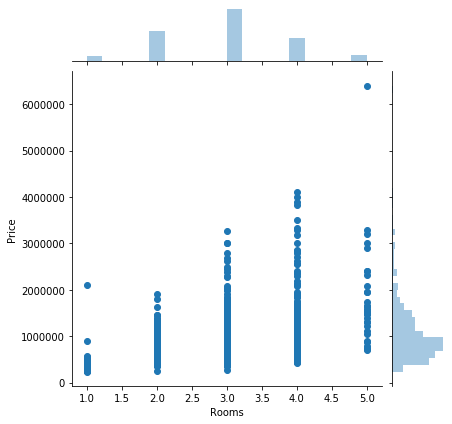

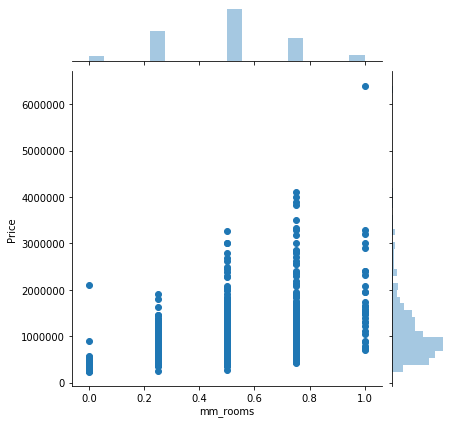

In [203]:
sns.jointplot(x="Rooms", y="Price", data=new_df_min_max)
sns.jointplot(x="mm_rooms", y="Price", data=new_df_min_max)
plt.show()

(<matplotlib.axes._subplots.AxesSubplot at 0x2618543a390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2618543a390>)

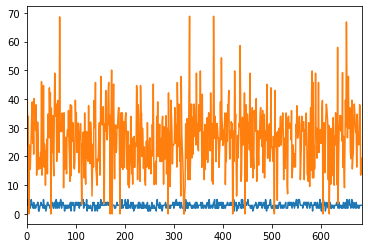

In [204]:
#sns.jointplot(x="mm_travel_min_to_CBD", y="Price", data=new_df_min_max)
##sns.jointplot(x="travel_min_to_CBD", y="Price", data=new_df_min_max)
#plt.show()
new_df_min_max["Rooms"].plot(),new_df_min_max["travel_min_to_CBD"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x26184e285f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26184e285f8>)

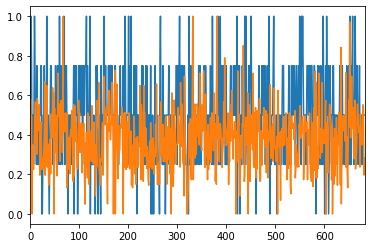

In [205]:
new_df_min_max["mm_rooms"].plot(),new_df_min_max["mm_travel_min_to_CBD"].plot()

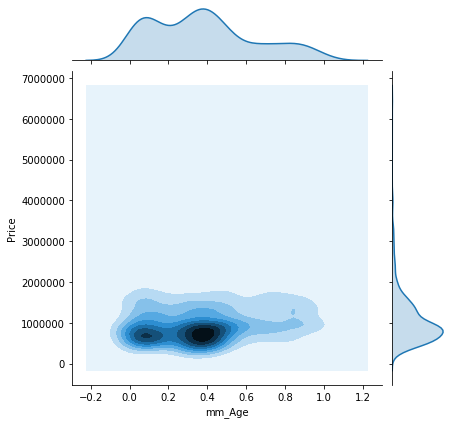

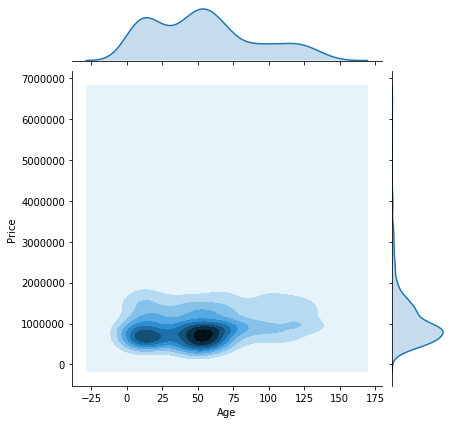

In [206]:
sns.jointplot(x="mm_Age", y="Price", data=new_df_min_max, kind="kde")
sns.jointplot(x="Age", y="Price", data=new_df_min_max, kind="kde");
plt.show()


We can see that only the values on the X_axis have been changed, but the distribution for those values before and after MinMax Normalization did not change

## Performing Z transformation

In the Z_score transformation, all the values are normalized based on the mean and Standard deviation.

In [207]:
from sklearn import preprocessing
df_minmax2 = preprocessing.StandardScaler().fit_transform(new_df_min_max[['Rooms','crime_C_average','travel_min_to_CBD','Age']])
df_minmax2[0:5]

array([[ 0.05243507,  0.66527957, -0.16015722,  0.41709112],
       [ 0.05243507, -0.11978282,  1.30503053, -0.27241566],
       [ 2.29403414, -0.2862128 , -0.23475449, -1.21014487],
       [ 1.1732346 ,  0.30968771,  0.73582091,  0.14128841],
       [-1.06836447, -0.21395783, -2.48970033,  1.52030196]])

In [208]:
new_df_min_max['z_rooms'] = df_minmax2[:,0]
new_df_min_max['z_crime_c_average'] = df_minmax2[:,1]
new_df_min_max['z_travel_min_to_CBD'] = df_minmax2[:,2]
new_df_min_max['z_Age'] = df_minmax2[:,3]



In [209]:
new_df_min_max[['Rooms','crime_C_average','travel_min_to_CBD','Age','z_rooms','z_crime_c_average','z_travel_min_to_CBD','z_Age']].describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,z_rooms,z_crime_c_average,z_travel_min_to_CBD,z_Age
count,684.000000,684.000000,684.000000,684.000000,6.840000e+02,6.840000e+02,6.840000e+02,6.840000e+02
mean,2.953216,426.180799,26.243762,53.877193,1.112049e-16,1.751361e-16,5.112869e-17,1.033936e-16
std,0.892873,410.883543,10.548646,36.284335,1.000732e+00,1.000732e+00,1.000732e+00,1.000732e+00
min,1.000000,0.000000,0.000000,2.000000,-2.189164e+00,-1.037989e+00,-2.489700e+00,-1.430787e+00
25%,2.000000,159.333333,19.090909,21.000000,-1.068364e+00,-6.499232e-01,-6.785788e-01,-9.067619e-01
50%,3.000000,333.000000,26.375000,49.000000,5.243507e-02,-2.269475e-01,1.245033e-02,-1.345143e-01
75%,3.000000,564.333333,32.403846,69.000000,5.243507e-02,3.364789e-01,5.843965e-01,4.170911e-01
max,5.000000,2042.333333,68.818182,139.000000,2.294034e+00,3.936238e+00,4.038962e+00,2.347710e+00


**Plotting real values vs Z normalized values**

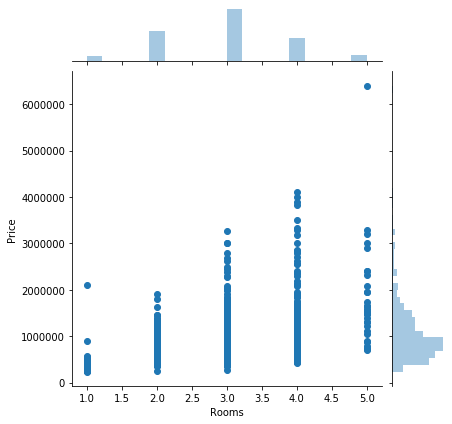

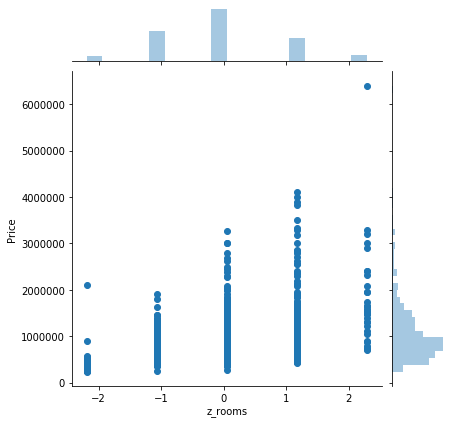

In [210]:
sns.jointplot(x="Rooms", y="Price", data=new_df_min_max)
sns.jointplot(x="z_rooms", y="Price", data=new_df_min_max)
plt.show()

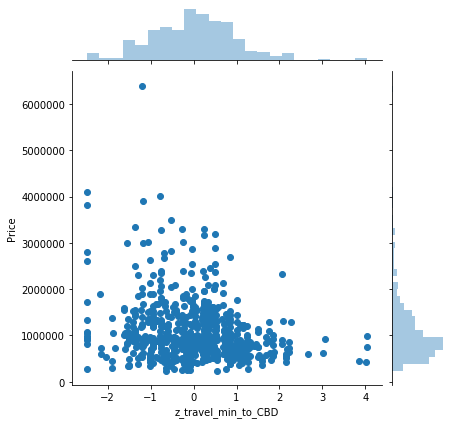

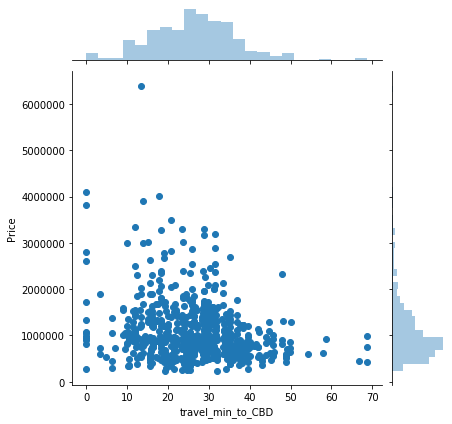

In [211]:
sns.jointplot(x="z_travel_min_to_CBD", y="Price", data=new_df_min_max)
sns.jointplot(x="travel_min_to_CBD", y="Price", data=new_df_min_max)
plt.show()

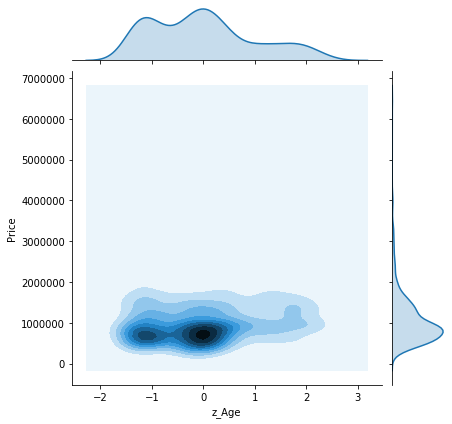

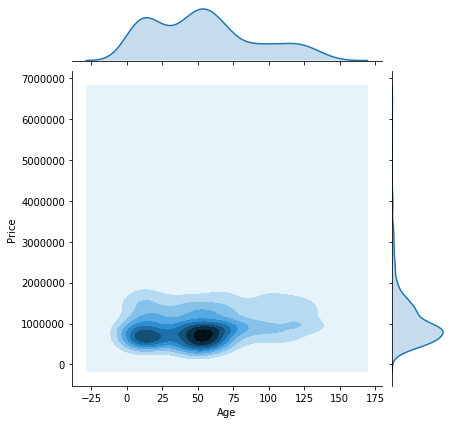

In [212]:
sns.jointplot(x="z_Age", y="Price", data=new_df_min_max, kind="kde")
sns.jointplot(x="Age", y="Price", data=new_df_min_max, kind="kde");
plt.show()



One advantage of Z-score over min-max transformation is the min-max always tries to get values closer to mean, but when we have outlier which are important then we will loose the impact of that outlier.

In our case as we dont have any outliers, and also performing these normalizations doesnot really affect any kind of correlation w.r.t to the target variable we can try apply other transformation techniques.

## Transformations

In [214]:
new_df_trans=new_df.copy() 

In [215]:
new_df_trans.columns

Index(['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age', 'Price'], dtype='object')

#### plotting histograms to check the distribution of each column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026185AF62E8>]],
      dtype=object)

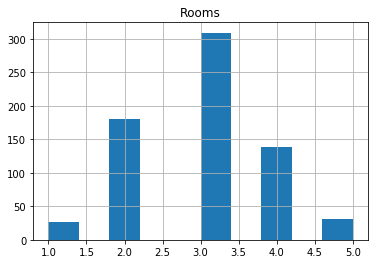

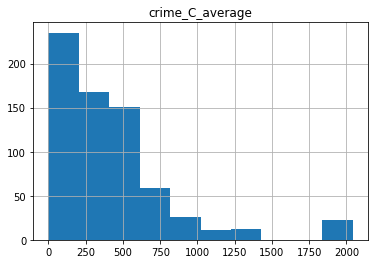

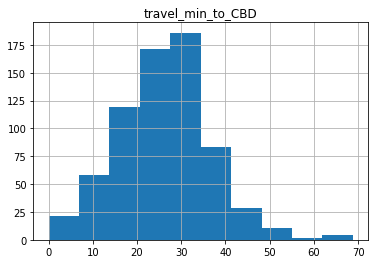

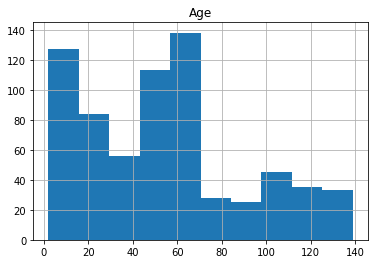

In [217]:
new_df_trans.hist("Rooms")
new_df_trans.hist("crime_C_average")
new_df_trans.hist("travel_min_to_CBD")
new_df_trans.hist("Age")

From the abov distribution graphs none of the columns are normally distributed and we need to perform few kind of transformation on these columns such that it might increase the correlation with the target variable and will be useful for good predictions

To check whether the transformation of columns will increase our predictions accuracy or not, we try to apply the following transformations on the `age` and `crime_c_average` column<br>
- square transformation
- log transformation
- root transformation

In [218]:
def square_transform(x):
    return x**2


In [219]:
def root_transform(x):
    return x**0.5

### Square transform for crime column

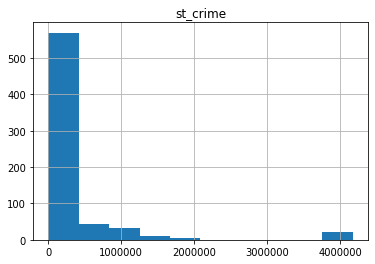

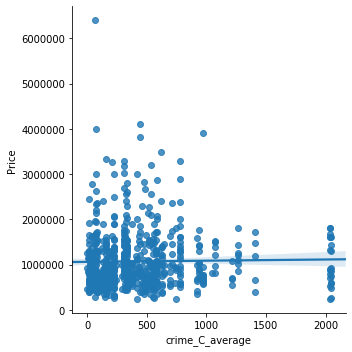

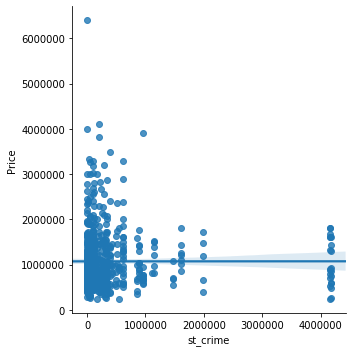

In [221]:
new_df_trans['st_crime']=new_df_trans['crime_C_average'].apply(square_transform)
new_df_trans.hist('st_crime')
sns.lmplot('crime_C_average','Price',data=new_df_trans,scatter=True)
sns.lmplot('st_crime','Price',data=new_df_trans,scatter=True)

Square transformation has compressed our column values hence you can see there is slight decrease in the correlation w.r.t to the target variable

### Root transform for crime column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026185DFD8D0>]],
      dtype=object)

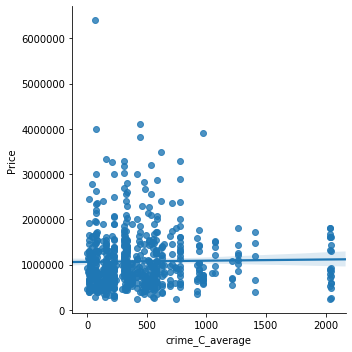

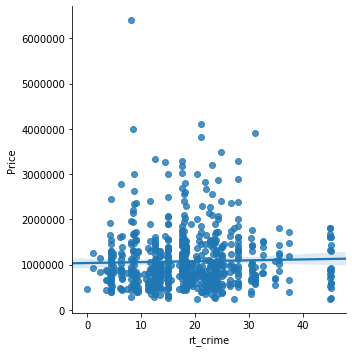

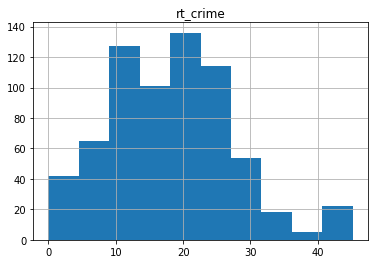

In [222]:
new_df_trans['rt_crime']=new_df_trans['crime_C_average'].apply(root_transform)
sns.lmplot('crime_C_average','Price',data=new_df_trans,scatter=True)
sns.lmplot('rt_crime','Price',data=new_df_trans,scatter=True)
new_df_trans.hist('rt_crime')

Now if you check the distribution of crime_c_average column, it is normally distributed.<br>
Root transform has spread our data in the column hence by increasing the correlation between feature and target variable a little.

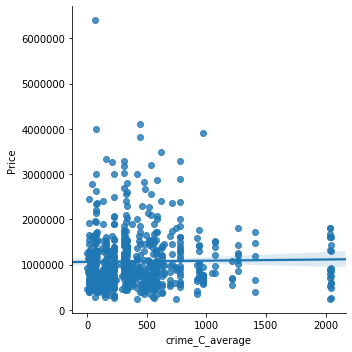

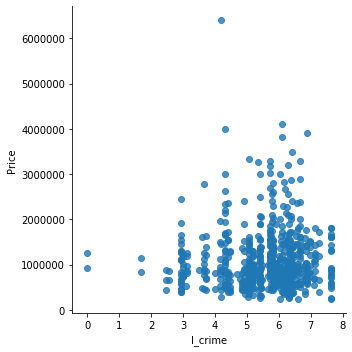

In [223]:
import numpy as np
new_df_trans['l_crime']=new_df_trans['crime_C_average'].apply(np.log)
sns.lmplot('crime_C_average','Price',data=new_df_trans,scatter=True)
sns.lmplot('l_crime','Price',data=new_df_trans,scatter=True)
#new_df_trans.hist('l_crime')

By performing log transformation on the crime_c_average data we see that all the data in the column has been obtained in left skewed distribution, hence log transformation on this column does not work well in good predictions

### Square transformation for age column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026185FAF748>]],
      dtype=object)

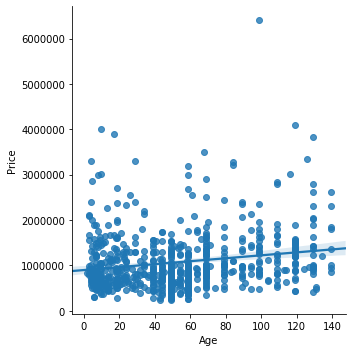

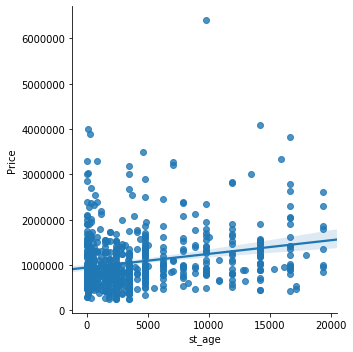

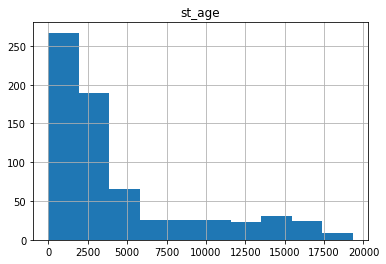

In [224]:
new_df_trans['st_age']=new_df_trans['Age'].apply(square_transform)
sns.lmplot('Age','Price',data=new_df_trans,scatter=True)
sns.lmplot('st_age','Price',data=new_df_trans,scatter=True)
new_df_trans.hist('st_age')

Performing square transformation on age column has changed the distribuiton of data to the right skewed, as points have been extended we can see that the relation between this square transformed variable and the target has been increased

## Root transform for age column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026186100FD0>]],
      dtype=object)

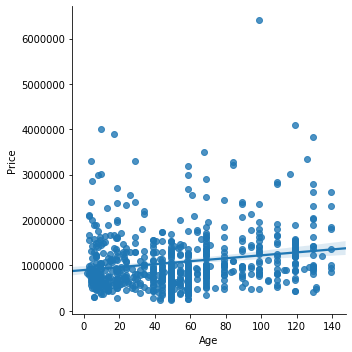

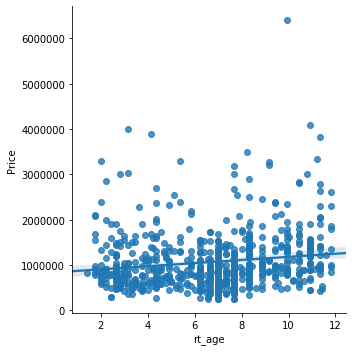

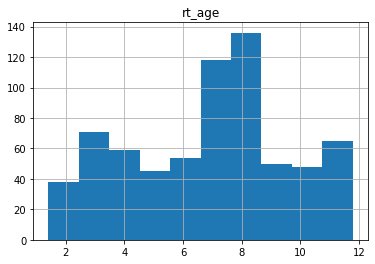

In [225]:
new_df_trans['rt_age']=new_df_trans['Age'].apply(root_transform)
sns.lmplot('Age','Price',data=new_df_trans,scatter=True)
sns.lmplot('rt_age','Price',data=new_df_trans,scatter=True)
new_df_trans.hist('rt_age')

performing root transformation has gave us a multimodel distribution for the data in the age column, because here we are shrinking the data which inturn reduces the relation to the target variable 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002618625C3C8>]],
      dtype=object)

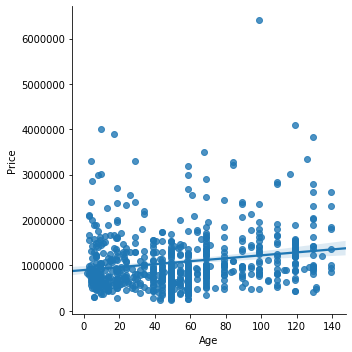

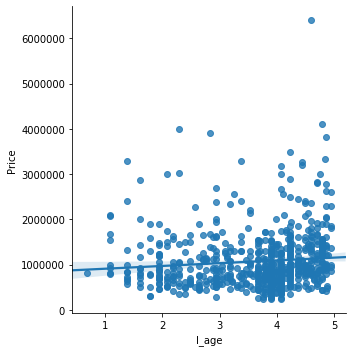

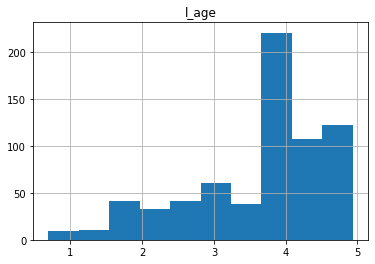

In [227]:
import numpy as np
new_df_trans['l_age']=new_df_trans['Age'].apply(np.log)
sns.lmplot('Age','Price',data=new_df_trans,scatter=True)
sns.lmplot('l_age','Price',data=new_df_trans,scatter=True)
new_df_trans.hist('l_age')

Out of all transformations and normalizations we see that **square transforming** the `crime_C_average` and `age` column are being streched hence by increasing the correlation with respect to the response or target variable

#### Building a model after square transforming the Crime and age columns

In [228]:
X_train, X_test, y_train, y_test = train_test_split(new_df_trans[['Rooms','st_crime','travel_min_to_CBD','st_age']],new_df['Price'],random_state=10)
lr=LinearRegression()
lr.fit(X_train,y_train)
print ('Rsquared for the transformed model is = ',lr.score(X_test,y_test))

Rsquared for the transformed model is =  0.36993520991389617


Before our RSquare value was `0.362`, now after doing Square transformation on the column RSquared value for the model has been increased to `0.3699`.<br>
This is a significant increase that has happened in predicting the prices

## Conclusion

- Reshaping and transforming the main aim of this assignment, we have learnt how to combining data from different locations and extracting them from different formats.
- After getting all data performing linear regression for predicting the prices and again reshaping, normalizing, transforming the data to improve the accuracy.
- We have included all the data which are extracted from various file format like, XML, geoJson, text and combined them into one useful CSV file in the required format.

## References

1. Pandas documentation:https://pandas.pydata.org/pandas-docs/stable/<br>
2. The geopandas documentation for spatial joining and reading the shape files to perform geobased calculations: http://geopandas.org/<br>
3. Matlplotlib for various charts https://matplotlib.org/3.1.0/contents.html<br>
4. Seaborn Gallery for plotting tthe graphs https://seaborn.pydata.org/<br>
5. The sklearn package for performing the regression analysis https://scikit-learn.org/stable/modules/linear_model.html